### Desafio 3
Modelo many to one usando Moby dick como corpus.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos

In [ ]:
from nltk.corpus import gutenberg
import nltk
nltk.download('gutenberg')
import nltk
nltk.download('punkt')
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
moby_dick = gutenberg.sents('melville-moby_dick.txt')

In [ ]:
len(moby_dick)

10059

In [ ]:
# Convierto cada sublista (oración) en una cadena de texto
sents_text = [' '.join(sentence) for sentence in moby_dick]

df = pd.DataFrame(sents_text, columns=['Lines'])
df

,Lines
0,[ Moby Dick by Herman Melville 1851 ]
1,ETYMOLOGY .
2,( Supplied by a Late Consumptive Usher to a Gr...
3,"The pale Usher -- threadbare in coat , heart ,..."
4,He was ever dusting his old lexicons and gramm...
...,...
10054,"Till , gaining that vital centre , the black b..."
10055,"Buoyed up by that coffin , for almost one whol..."
10056,"The unharming sharks , they glided by as if wi..."
10057,"On the second day , a sail drew near , nearer ..."


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 10059


### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
# cada verso lo guardamos en una lista
text = list(df.iloc[:,0])
text[0:10]

['[ Moby Dick by Herman Melville 1851 ]',
 'ETYMOLOGY .',
 '( Supplied by a Late Consumptive Usher to a Grammar School )',
 'The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now .',
 'He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world .',
 'He loved to dust his old grammars ; it somehow mildly reminded him of his mortality .',
 '" While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ."',
 '-- HACKLUYT',
 '" WHALE .',
 '... Sw . and Dan .']

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([4.748e+03, 2.917e+03, 1.345e+03, 6.150e+02, 2.490e+02, 9.600e+01,
        4.000e+01, 2.000e+01, 1.200e+01, 7.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.        ,  15.83333333,  31.66666667,  47.5       ,
         63.33333333,  79.16666667,  95.        , 110.83333333,
        126.66666667, 142.5       , 158.33333333, 174.16666667,
        190.        , 205.83333333, 221.66666667, 237.5       ,
        253.33333333, 269.16666667, 285.        , 300.83333333,
        316.66666667, 332.5       , 348.33333333, 364.16666667,
        380.        , 395.83333333, 411.66666667, 427.5       ,
        443.33333333, 459.16666667, 475.        ]),
 <BarContainer object of 30 artists>)

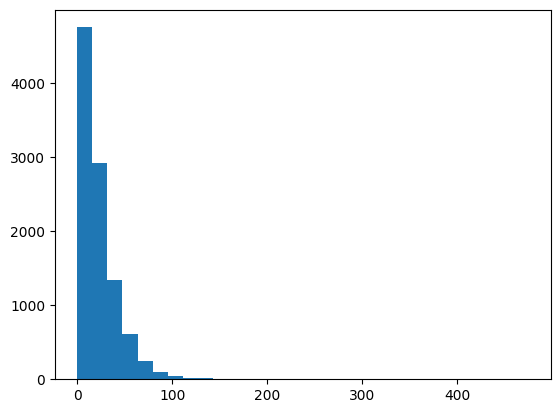

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=30)

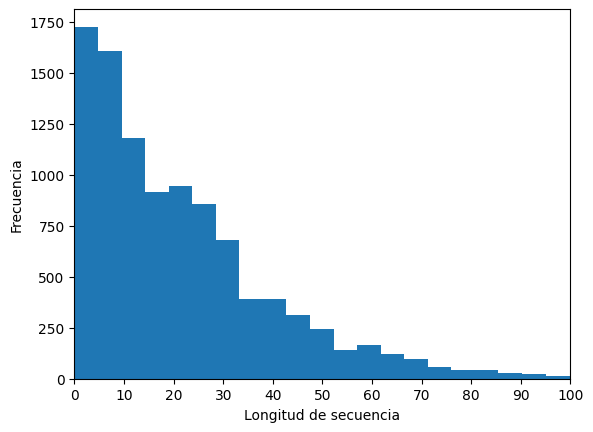

In [ ]:
plt.hist(length_sentences, bins=100)
plt.xlabel('Longitud de secuencia')
plt.ylabel('Frecuencia')
plt.xlim(0, 100)
plt.xticks(range(0, 101, 10))

plt.show()

In [ ]:
df_lenght_sentences = pd.DataFrame(length_sentences)
df_lenght_sentences.describe()

,0
count,10059.000000
mean,22.024157
std,21.044143
min,0.000000
25%,7.000000
50%,17.000000
75%,31.000000
max,475.000000


In [ ]:
np.percentile(df_lenght_sentences,90)

48.0

{'whiskers': [<matplotlib.lines.Line2D at 0x7e399cdf3d00>,
 'caps': [<matplotlib.lines.Line2D at 0x7e399cdf0820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e399cdf1870>],
 'medians': [<matplotlib.lines.Line2D at 0x7e399cdf2dd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e399cdf0e20>],
 'means': []}

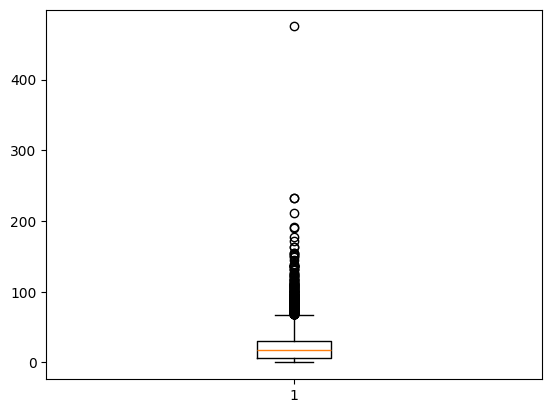

In [ ]:
plt.boxplot(length_sentences)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 47


In [ ]:
#Decido elegir un valor cercano al p75
max_context_size = 30

In [ ]:
print(len(segmented_sentences))
segmented_sentences = [sentence for sentence in segmented_sentences if len(sentence) > 0]

print(len(segmented_sentences))

10059
10033


###  Tokenizar

In [ ]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
max_context_size+1

31

In [ ]:
tokenized_sentences[0]

[281, 282, 24, 9602, 9603, 5109]

In [ ]:
text[0]

'[ Moby Dick by Herman Melville 1851 ]'

### Organizando y estructurando el dataset

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [ ]:
len(tokenized_sentences_train)

8026

In [ ]:
largo_listas = [len(sublista) for sublista in tokenized_sentences_train]
print(largo_listas)

[22, 36, 22, 1, 27, 17, 51, 6, 22, 29, 44, 2, 5, 8, 10, 17, 9, 2, 29, 6, 3, 4, 16, 9, 14, 10, 31, 24, 19, 30, 15, 1, 2, 36, 3, 18, 14, 11, 2, 34, 16, 8, 25, 2, 4, 17, 21, 22, 13, 13, 20, 15, 15, 44, 38, 85, 1, 19, 5, 21, 36, 33, 4, 10, 12, 16, 11, 15, 5, 29, 2, 2, 58, 2, 32, 61, 61, 6, 3, 16, 28, 27, 17, 12, 26, 38, 30, 18, 66, 15, 6, 22, 42, 14, 1, 4, 2, 22, 30, 1, 7, 10, 2, 15, 16, 47, 70, 2, 34, 63, 41, 63, 33, 12, 61, 28, 24, 51, 2, 1, 69, 5, 88, 13, 17, 33, 49, 10, 21, 35, 11, 5, 24, 39, 61, 30, 18, 10, 11, 24, 48, 36, 2, 1, 8, 8, 1, 16, 4, 21, 66, 37, 33, 28, 4, 12, 43, 9, 37, 13, 3, 85, 29, 10, 23, 17, 47, 15, 15, 24, 9, 30, 36, 32, 11, 53, 92, 1, 14, 16, 57, 11, 24, 30, 10, 19, 6, 36, 57, 22, 33, 39, 10, 14, 1, 49, 11, 2, 9, 8, 39, 15, 37, 15, 41, 16, 20, 11, 48, 7, 41, 2, 3, 53, 16, 17, 10, 2, 41, 24, 27, 50, 75, 28, 59, 58, 30, 155, 13, 1, 20, 19, 9, 6, 2, 39, 41, 4, 6, 21, 16, 41, 82, 18, 55, 40, 2, 6, 81, 59, 34, 40, 23, 12, 16, 63, 22, 14, 4, 30, 7, 62, 1, 44, 41, 46, 4, 8

Split de las oraciones que tienen tamaño mayor al contexto máximo, para generar más secuencias de entrenamiento.

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
largo_listas = [len(sublista) for sublista in tok_sent]
print(largo_listas)

[22, 31, 31, 31, 31, 31, 31, 22, 1, 27, 17, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 6, 22, 29, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 2, 5, 8, 10, 17, 9, 2, 29, 6, 3, 4, 16, 9, 14, 10, 31, 24, 19, 30, 15, 1, 2, 31, 31, 31, 31, 31, 31, 3, 18, 14, 11, 2, 31, 31, 31, 31, 16, 8, 25, 2, 4, 17, 21, 22, 13, 13, 20, 15, 15, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 1, 19, 5, 21, 31, 31, 31, 31, 31, 31, 31, 31, 31, 4, 10, 12, 16, 11, 15, 5, 29, 2, 2, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 2, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 

In [ ]:
set(largo_listas)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31}

In [ ]:
len(tok_sent)

47400

 Aumento de los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
largo_listas = [len(sublista) for sublista in tok_sent_augm]
print(largo_listas)

[21, 30, 30, 30, 30, 30, 30, 21, 0, 26, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 5, 21, 28, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 1, 4, 7, 9, 16, 8, 1, 28, 5, 2, 3, 15, 8, 13, 9, 30, 23, 18, 29, 14, 0, 1, 30, 30, 30, 30, 30, 30, 2, 17, 13, 10, 1, 30, 30, 30, 30, 15, 7, 24, 1, 3, 16, 20, 21, 12, 12, 19, 14, 14, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 0, 18, 4, 20, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3, 9, 11, 15, 10, 14, 4, 28, 1, 1, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 1, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

In [ ]:
tokenized_sentences_train[0]

[398,
 158,
 4,
 301,
 57,
 1,
 3550,
 18,
 963,
 868,
 1014,
 73,
 52,
 1,
 162,
 20,
 83,
 1791,
 3665,
 16680,
 17,
 120]

In [ ]:
tok_sent[0]

[398,
 158,
 4,
 301,
 57,
 1,
 3550,
 18,
 963,
 868,
 1014,
 73,
 52,
 1,
 162,
 20,
 83,
 1791,
 3665,
 16680,
 17,
 120]

In [ ]:
len(tok_sent_augm[0][0])

31

In [ ]:
tok_sent_augm[0][0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 398, 158], dtype=int32)

In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [ ]:
train_seqs.shape

(1312943, 31)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [ ]:
train_seqs[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 398, 158], dtype=int32)

In [ ]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 398], dtype=int32)

In [ ]:
y[0]

158

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'a',
 5: 'to',
 6: 'in',
 7: 'that',
 8: "'",
 9: 'his',
 10: 'it',
 11: 'i',
 12: 'he',
 13: 'but',
 14: 's',
 15: 'as',
 16: 'is',
 17: 'with',
 18: 'was',
 19: 'for',
 20: 'all',
 21: 'this',
 22: 'at',
 23: 'whale',
 24: 'by',
 25: 'not',
 26: 'from',
 27: 'him',
 28: 'so',
 29: 'on',
 30: 'be',
 31: 'one',
 32: 'you',
 33: 'there',
 34: 'now',
 35: 'had',
 36: 'have',
 37: 'or',
 38: 'were',
 39: 'they',
 40: 'which',
 41: 'like',
 42: 'me',
 43: 'then',
 44: 'their',
 45: 'what',
 46: 'some',
 47: 'when',
 48: 'are',
 49: 'an',
 50: 'my',
 51: 'no',
 52: 'upon',
 53: 'out',
 54: 'man',
 55: 'into',
 56: 'up',
 57: 'ship',
 58: 'ahab',
 59: 'more',
 60: 'if',
 61: 'them',
 62: 'ye',
 63: 'we',
 64: 'sea',
 65: 'old',
 66: 'would',
 67: 'other',
 68: 'been',
 69: 'over',
 70: 'these',
 71: 'will',
 72: 'though',
 73: 'down',
 74: 'its',
 75: 'only',
 76: 'such',
 77: 'who',
 78: 'head',
 79: 'yet',
 80: 'boat',
 81: 'time',
 82: 'long',
 83: 'her

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

17140

In [ ]:
vocab_size**(1/4)

11.442020048593916

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'of': 2, 'and': 3, 'a': 4, 'to': 5, 'in': 6, 'that': 7, "'": 8, 'his': 9, 'it': 10, 'i': 11, 'he': 12, 'but': 13, 's': 14, 'as': 15, 'is': 16, 'with': 17, 'was': 18, 'for': 19, 'all': 20, 'this': 21, 'at': 22, 'whale': 23, 'by': 24, 'not': 25, 'from': 26, 'him': 27, 'so': 28, 'on': 29, 'be': 30, 'one': 31, 'you': 32, 'there': 33, 'now': 34, 'had': 35, 'have': 36, 'or': 37, 'were': 38, 'they': 39, 'which': 40, 'like': 41, 'me': 42, 'then': 43, 'their': 44, 'what': 45, 'some': 46, 'when': 47, 'are': 48, 'an': 49, 'my': 50, 'no': 51, 'upon': 52, 'out': 53, 'man': 54, 'into': 55, 'up': 56, 'ship': 57, 'ahab': 58, 'more': 59, 'if': 60, 'them': 61, 'ye': 62, 'we': 63, 'sea': 64, 'old': 65, 'would': 66, 'other': 67, 'been': 68, 'over': 69, 'these': 70, 'will': 71, 'though': 72, 'down': 73, 'its': 74, 'only': 75, 'such': 76, 'who': 77, 'head': 78, 'yet': 79, 'boat': 80, 'time': 81, 'long': 82, 'her': 83, 'captain': 84, 'any': 85, 'here': 86, 'very': 87, 'still': 88, 'about': 89, 'th

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'by': 1032, 'melville': 1, 'moby': 79, '1851': 3, 'herman': 1, 'dick': 79, 'etymology': 1, 'grammar': 2, 'late': 30, 'supplied': 12, 'a': 3155, 'to': 3189, 'consumptive': 1, 'school': 9, 'usher': 2, 'the': 5750, 'threadbare': 1, 'heart': 89, 'body': 108, 'brain': 34, 'i': 1605, 'coat': 26, 'see': 263, 'pale': 18, 'now': 753, 'and': 3888, 'him': 877, 'in': 2988, 'of': 3784, 'world': 173, 'old': 412, 'queer': 33, 'was': 1338, 'nations': 12, 'lexicons': 1, 'dusting': 2, 'mockingly': 1, 'with': 1464, 'ever': 196, 'known': 78, 'flags': 1, 'gay': 21, 'all': 1335, 'grammars': 2, 'his': 1729, 'he': 1474, 'embellished': 3, 'handkerchief': 5, 'dust': 10, 'loved': 3, 'mildly': 10, 'somehow': 44, 'reminded': 4, 'it': 2009, 'mortality': 1, 'teach': 5, 'hand': 201, 'take': 131, 'fish': 153, 'be': 905, 'word': 75, 'deliver': 3, 'leaving': 37, 'almost': 189, 'name': 68, 'maketh': 5, 'signification': 1, 'out': 507, 'h': 3, 'whale': 1086, 'our': 176, 'you': 670, 'is': 1403, '


### Definir el modelo

In [ ]:
from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim= 20, input_shape=(max_context_size+1,)))

model.add((LSTM(64*2, return_sequences=True)))
model.add(Dropout(0.3))
model.add((LSTM(64)))

model.add(Dense(vocab_size+1, activation='softmax'))


#optimizador = Adam(learning_rate=0.001)
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 31, 20)              │         342,820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 31, 128)             │          76,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17141)               │       1,114,165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,582,681 (6.04 MB)

 Trainable params: 1,582,681 (6.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

In [ ]:
X.shape

(1312943, 30)

### Entrenamiento

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, mientras más grande mejor.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=1000)

Epoch 1/20
1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.1275
 mean perplexity: 25028.065074152226 

Saved new model!
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 48s 33ms/step - loss: 7.1270
Epoch 2/20
1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.3580
 mean perplexity: 80844.1611975756 

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - loss: 6.3578
Epoch 3/20
1312/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.8912
 mean perplexity: 225052.20513292923 

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/step - loss: 5.8911
Epoch 4/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.6025
 mean perplexity: 669828.5429237942 

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - loss: 5.6024
Epoch 5/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.3721
 mean perplexity: 1245672.1853423472 

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - loss: 5.3721
Epoch 6/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.1786
 mean perplexity: 1049531.2579442644 

Stopping training...
1313/1313 ━

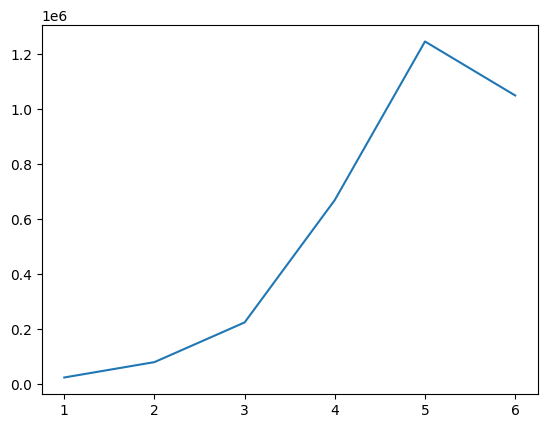

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()


In [ ]:

# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción de próxima palabra

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.5 MB/s eta 0:00:00


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ce7fe45848b267611e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ce7fe45848b267611e.gradio.live


### Generación de secuencias

In [60]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [61]:

input_text='On the second day\'t'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


"On the second day't whale the whale the whale the whale the whale the"

###  Beam search y muestreo aleatorio

In [62]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [63]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens


In [64]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="On the second day",temp=1,mode='sto')

In [65]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 36)

In [66]:
# veamos las salidas
decode(salidas[0])

['on the second day in the by the great no']

In [67]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="On the second day",temp=1,mode='det')

In [68]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 36)

In [69]:
# veamos las salidas
decode(salidas[0])

['on the second day of of of of of the']

Evidentemente el modelo no esta aprendiendo, esto se puede ver porque aumenta la perplejidad y los resultados que se ven al predecir las próximas palabras.